# imports

In [1]:
import sys
from datetime import datetime
from nltk import tokenize
import matplotlib.pyplot as plt
import re
import csv
import itertools
import operator
import numpy as np
import nltk
%matplotlib inline
from IPython import display
plt.style.use('seaborn-white')

# Load 3 Text Books and Concatenate 

In [2]:
#text files concatenation 
filenames = ['A_Journey_to_the_Center_of_the_Earth.txt', 'From_the_Earth_to_the_Moon.txt', 'The_master_of_the_world.txt']
with open('/Users/pprusty05/google_drive/Deep_Learning/assignment3/Text_file_for_training.txt', 'w+') as outfile:
    for fname in filenames:
        with open(fname) as infile:
            for line in infile:
                outfile.write(line)

In [3]:
train_data = open('Text_file_for_training.txt', 'r').read() 

#print(train_data)


# Preprocessing 

In [4]:
vocabulary_size = 5000
unknown_token = "UNKNOWN"
sentence_start_token = "SENTENCE_START"
sentence_end_token = "SENTENCE_END"

## Clean Text file, tokenize sentences and append sentence start and end token 

In [5]:
with open ('Text_file_for_training.txt', 'r') as f:
    
    text = f.read()
    tokenized_sent = nltk.sent_tokenize(text)
    sentences=[x.replace('\n',' ') for x in tokenized_sent]
    sentences = [re.sub('[^a-zA-Z0-9]', ' ', x)for x in tokenized_sent]
    sentences = [word.lower() for word in sentences]

    #sentences = itertools.chain(*[tokenize.sent_tokenize(x) for x in f])
    sentences = ["%s %s %s" % (sentence_start_token, x, sentence_end_token) for x in sentences]
    
print( "Parsed %d sentences." % (len(sentences)))

    


Parsed 13926 sentences.


# Tokenize Word

In [6]:
# Tokenize the sentences into words
tokenized_words = [nltk.word_tokenize(sent) for sent in sentences]

# Claculate word frequency and build index_to_word and word_to_index vectors

In [7]:
# Count the word frequencies
word_freq = nltk.FreqDist(itertools.chain(*tokenized_words))
print("Found %d unique words tokens." % len(word_freq.items()))

Found 13079 unique words tokens.


In [8]:
word_freq

FreqDist({'the': 17484, 'SENTENCE_START': 13926, 'SENTENCE_END': 13926, 'of': 9369, 'to': 6171, 'and': 5424, 'a': 4466, 'in': 3619, 'i': 3275, 'was': 2858, ...})

In [9]:
# Get the most common words and build index_to_word and word_to_index vectors
vocab = word_freq.most_common(vocabulary_size-1)
index_to_word = [x[0] for x in vocab]
index_to_word.append(unknown_token)
word_to_index = dict([(w,i) for i,w in enumerate(index_to_word)])

In [10]:
print("Using vocabulary size %d." % vocabulary_size)
print("The least frequent word in our vocabulary is '%s' and appeared %d times." % (vocab[-1][0], vocab[-1][1]))
word_freq.most_common(10)

Using vocabulary size 5000.
The least frequent word in our vocabulary is 'clamps' and appeared 3 times.


[('the', 17484),
 ('SENTENCE_START', 13926),
 ('SENTENCE_END', 13926),
 ('of', 9369),
 ('to', 6171),
 ('and', 5424),
 ('a', 4466),
 ('in', 3619),
 ('i', 3275),
 ('was', 2858)]

In [11]:
# Replace all words not in our vocabulary with the unknown token
for i, sent in enumerate(tokenized_words):
    tokenized_words[i] = [w if w in word_to_index else unknown_token for w in sent]

In [12]:
print("\nExample sentence: '%s'" % sentences[0])
print("\nExample sentence after Pre-processing: '%s'" % tokenized_words[0])


Example sentence: 'SENTENCE_START project gutenberg s a journey to the centre of the earth  by jules verne  this ebook is for the use of anyone anywhere at no cost and with almost no restrictions whatsoever  SENTENCE_END'

Example sentence after Pre-processing: '['SENTENCE_START', 'project', 'gutenberg', 's', 'a', 'journey', 'to', 'the', 'centre', 'of', 'the', 'earth', 'by', 'jules', 'verne', 'this', 'ebook', 'is', 'for', 'the', 'use', 'of', 'anyone', 'anywhere', 'at', 'no', 'cost', 'and', 'with', 'almost', 'no', 'restrictions', 'whatsoever', 'SENTENCE_END']'


# XTrain and yTrain 

In [13]:
# Create the training data
XTrain = np.asarray([[word_to_index[w] for w in sent[:-1]] for sent in tokenized_words])
yTrain = np.asarray([[word_to_index[w] for w in sent[1:]] for sent in tokenized_words])

In [14]:
XTrain.shape

(13926,)

In [15]:
yTrain.shape

(13926,)

In [16]:
# Print an training data example
x_example, y_example = XTrain[17], yTrain[17]
print ("x:\n%s\n%s" % (" ".join([index_to_word[x] for x in x_example]), x_example))
print ("\ny:\n%s\n%s" % (" ".join([index_to_word[x] for x in y_example]), y_example))

x:
SENTENCE_START to bear with him means to obey and scarcely had his heavy feet resounded within our UNKNOWN UNKNOWN than he shouted for me to attend upon him
[1, 4, 1159, 19, 76, 216, 4, 3249, 5, 332, 20, 26, 488, 104, 3250, 226, 34, 4999, 4999, 75, 25, 2649, 27, 47, 4, 4913, 62, 76]

y:
to bear with him means to obey and scarcely had his heavy feet resounded within our UNKNOWN UNKNOWN than he shouted for me to attend upon him SENTENCE_END
[4, 1159, 19, 76, 216, 4, 3249, 5, 332, 20, 26, 488, 104, 3250, 226, 34, 4999, 4999, 75, 25, 2649, 27, 47, 4, 4913, 62, 76, 2]


# Task 4: Word-level LSTM RNN

In [47]:
data_size,vocab_size = len(train_data), vocabulary_size

In [66]:
# Constants and hyper-params
H_size = 10 # Size of the hidden layer
T_steps = 10
# Number of time steps (length of the sequence) used for training
learning_rate = 0.005 # Learning rate
weight_sd = 0.1 # Standard deviation of weights for initialization
z_size = H_size + vocab_size # Size of concatenate(H, X) vector

In [67]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))


def dsigmoid(y):
    return y * (1 - y)


def tanh(x):
    return np.tanh(x)


def dtanh(y):
    return 1 - y * y

In [68]:
# Parameters
# We use random weights with normal distribution (0, weight_sd) for  tanh  activation function 
# and (0.5, weight_sd) for  sigmoid  activation function.
# Biases are initialized to zeros.
class Param:
    def __init__(self, name, value):
        self.name = name
        self.v = value #parameter value
        self.d = np.zeros_like(value) #derivative
        self.m = np.zeros_like(value) #momentum for AdaGrad
        
class Parameters:
    def __init__(self):
        self.W_f = Param('W_f', 
                         np.random.randn(H_size, z_size) * weight_sd + 0.5)
        self.b_f = Param('b_f',
                         np.zeros((H_size, 1)))

        self.W_i = Param('W_i',
                         np.random.randn(H_size, z_size) * weight_sd + 0.5)
        self.b_i = Param('b_i',
                         np.zeros((H_size, 1)))

        self.W_C = Param('W_C',
                         np.random.randn(H_size, z_size) * weight_sd)
        self.b_C = Param('b_C',
                         np.zeros((H_size, 1)))

        self.W_o = Param('W_o',
                         np.random.randn(H_size, z_size) * weight_sd + 0.5)
        self.b_o = Param('b_o',
                         np.zeros((H_size, 1)))

        #For final layer to predict the next character
        self.W_v = Param('W_v',
                         np.random.randn(vocab_size, H_size) * weight_sd)
        self.b_v = Param('b_v',
                         np.zeros((vocab_size, 1)))
        
    def all(self):
        return [self.W_f, self.W_i, self.W_C, self.W_o, self.W_v,
               self.b_f, self.b_i, self.b_C, self.b_o, self.b_v]
        
parameters = Parameters()

In [69]:
def forward(x, h_prev, C_prev, p = parameters):
    assert x.shape == (vocab_size, 1)
    assert h_prev.shape == (H_size, 1)
    assert C_prev.shape == (H_size, 1)
    
    z = np.row_stack((h_prev, x))
    f = sigmoid(np.dot(p.W_f.v, z) + p.b_f.v)
    i = sigmoid(np.dot(p.W_i.v, z) + p.b_i.v)
    C_bar = tanh(np.dot(p.W_C.v, z) + p.b_C.v)

    C = f * C_prev + i * C_bar
    o = sigmoid(np.dot(p.W_o.v, z) + p.b_o.v)
    h = o * tanh(C)

    v = np.dot(p.W_v.v, h) + p.b_v.v
    y = np.exp(v) / np.sum(np.exp(v))  #softmax

    return z, f, i, C_bar, C, o, h, v, y

In [70]:
dummyVector = np.random.randn(10, 1)
sigmoid(dummyVector)

array([[0.82471509],
       [0.84188191],
       [0.37508933],
       [0.41195958],
       [0.11231604],
       [0.44814117],
       [0.66069392],
       [0.37512382],
       [0.45957785],
       [0.75864027]])

In [71]:
def backward(target, dh_next, dC_next, C_prev,
             z, f, i, C_bar, C, o, h, v, y,
             p = parameters):
    
    assert z.shape == (vocab_size + H_size, 1)
    assert v.shape == (vocab_size, 1)
    assert y.shape == (vocab_size, 1)
    
    for param in [dh_next, dC_next, C_prev, f, i, C_bar, C, o, h]:
        assert param.shape == (H_size, 1)
        
    dv = np.copy(y)
    dv[target] -= 1

    p.W_v.d += np.dot(dv, h.T)
    p.b_v.d += dv

    dh = np.dot(p.W_v.v.T, dv)        
    dh += dh_next
    do = dh * tanh(C)
    do = dsigmoid(o) * do
    p.W_o.d += np.dot(do, z.T)
    p.b_o.d += do

    dC = np.copy(dC_next)
    dC += dh * o * dtanh(tanh(C))
    dC_bar = dC * i
    dC_bar = dtanh(C_bar) * dC_bar
    p.W_C.d += np.dot(dC_bar, z.T)
    p.b_C.d += dC_bar

    di = dC * C_bar
    di = dsigmoid(i) * di
    p.W_i.d += np.dot(di, z.T)
    p.b_i.d += di

    df = dC * C_prev
    df = dsigmoid(f) * df
    p.W_f.d += np.dot(df, z.T)
    p.b_f.d += df

    dz = (np.dot(p.W_f.v.T, df)
         + np.dot(p.W_i.v.T, di)
         + np.dot(p.W_C.v.T, dC_bar)
         + np.dot(p.W_o.v.T, do))
    dh_prev = dz[:H_size, :]
    dC_prev = f * dC
    
    return dh_prev, dC_prev

In [72]:
# Clear gradients before each backward pass
def clear_gradients(params = parameters):
    for p in params.all():
        p.d.fill(0)

In [73]:
 #Clip gradients to mitigate exploding gradients
def clip_gradients(params = parameters):
    for p in params.all():
        np.clip(p.d, -1, 1, out=p.d)

In [74]:
def calculate_total_loss(self, x, y):
    L = 0
    
    # For each sentence...
    for i in np.arange(len(y)):
        o, s = self.forward_propagation(x[i])
        
        # We only care about our prediction of the "correct" words
        correct_word_predictions = o[np.arange(len(y[i])), y[i]]
        
        # Add to the loss based on how off we were
        L += -1 * sum(np.log(correct_word_predictions))
    return L
 
def calculate_loss(self, x, y):
    # Divide the total loss by the number of training examples
    N = sum((len(y_i) for y_i in y))
    return self.calculate_total_loss(x,y)/N

In [75]:

def forward_backward(inputs, targets, h_prev, C_prev):
    global paramters
    
    # To store the values for each time step
    x_s, z_s, f_s, i_s,  = {}, {}, {}, {}
    C_bar_s, C_s, o_s, h_s = {}, {}, {}, {}
    v_s, y_s =  {}, {}
    
    # Values at t - 1
    h_s[-1] = np.copy(h_prev)
    C_s[-1] = np.copy(C_prev)
    
    loss = 0
    # Loop through time steps
    #assert len(inputs) == T_steps
    for t in range(len(inputs)):
        x_s[t] = np.zeros((vocab_size, 1))
        x_s[t][inputs[t]] = 1 # Input character
        
        (z_s[t], f_s[t], i_s[t],
        C_bar_s[t], C_s[t], o_s[t], h_s[t],
        v_s[t], y_s[t]) = \
            forward(x_s[t], h_s[t - 1], C_s[t - 1]) # Forward pass
        #print(y_s[t].shape)
        #print(len(targets[t]))
        #print(o_s[t].shape)
        #print(targets[t])
                 # We only care about our prediction of the "correct" words
        #correct_word_predictions = y_s[t][len(targets[t]), 0]
       
        
        # Add to the loss based on how off we were
        #loss += -1 * sum(math.log(correct_word_predictions))   
        loss += -np.log(y_s[t][len(targets[t]), 0]) # Loss for at t
        
    clear_gradients()

    dh_next = np.zeros_like(h_s[0]) #dh from the next character
    dC_next = np.zeros_like(C_s[0]) #dh from the next character

    for t in reversed(range(len(inputs))):
        # Backward pass
        dh_next, dC_next = \
            backward(target = targets[t], dh_next = dh_next,
                     dC_next = dC_next, C_prev = C_s[t-1],
                     z = z_s[t], f = f_s[t], i = i_s[t], C_bar = C_bar_s[t],
                     C = C_s[t], o = o_s[t], h = h_s[t], v = v_s[t],
                     y = y_s[t])

    clip_gradients()
        
    return loss, h_s[len(inputs) - 1], C_s[len(inputs) - 1]

In [76]:
def generate_next_word(h_prev, C_prev, first_char_idx, sentence_length):
    x = np.zeros((vocab_size, 1))
    x[first_char_idx] = 1

    h = h_prev
    C = C_prev

    indexes = []
    
    for t in range(sentence_length):
        _, _, _, _, C, _, h, _, p = forward(x, h, C)
        idx = np.random.choice(range(vocab_size), p=p.ravel())
        x = np.zeros((vocab_size, 1))
        x[idx] = 1
        indexes.append(idx)

    return indexes

In [77]:

# Update the graph and display a sample output
def update_status(inputs, h_prev, C_prev):
    #initialized later
    global plot_iter, plot_loss
    global smooth_loss
    
    # Get predictions for 200 letters with current model

    sample_idx = generate_next_word(h_prev, C_prev, inputs[1], len(inputs))
    txt = ' '.join(index_to_word[idx] for idx in sample_idx)

    # Clear and plot
    plt.plot(plot_iter, plot_loss)
    display.clear_output(wait=True)
    plt.show()

    #Print prediction and loss
    print("----\n %s \n----" % (txt, ))
    print("iter %d, loss %f" % (iteration, smooth_loss))

In [78]:
def update_paramters(params = parameters):
    for p in params.all():
        p.m += p.d * p.d # Calculate sum of gradients
        #print(learning_rate * dparam)
        p.v += -(learning_rate * p.d / np.sqrt(p.m + 1e-8))

In [79]:
# To delay the keyboard interrupt to prevent the training from stopping in the middle of an iteration
import signal

class DelayedKeyboardInterrupt(object):
    def __enter__(self):
        self.signal_received = False
        self.old_handler = signal.signal(signal.SIGINT, self.handler)

    def handler(self, sig, frame):
        self.signal_received = (sig, frame)
        print('SIGINT received. Delaying KeyboardInterrupt.')

    def __exit__(self, type, value, traceback):
        signal.signal(signal.SIGINT, self.old_handler)
        if self.signal_received:
            self.old_handler(*self.signal_received)

In [80]:
# Exponential average of loss
# Initialize to a error of a random model
smooth_loss = -np.log(1.0 / vocab_size) * T_steps

iteration, pointer = 0, 0

# For the graph
plot_iter = np.zeros((0))
plot_loss = np.zeros((0))

In [81]:
smooth_loss
#smooth_loss2 = -np.log(1.0 / vocab_size) * T_steps

85.17193191416239

In [82]:
# Update the graph and display a sample output
def print_status(inputs, h_prev, C_prev):
    # Get predictions for 200 letters with current model
    sample_idx = generate_next_word(h_prev, C_prev, inputs[0], 20)
    txt = ' '.join(index_to_word[idx] for idx in sample_idx)
    # Clear and plot
    #plt.plot(plot_iter, plot_loss)
    #display.clear_output(wait=True)
    #plt.show()
    #Print prediction and loss
    print("----\n %s \n----" % (txt, ))

prediction at breakpoint:  10
----
 post ancient passion advanced mountains impassive ensure descend became eclipse flame allowing surprises excessive fury content rest master retreat do 
----
prediction at breakpoint:  20
----
 owns composed connecticut perfectly trembled afraid duel magic dream astronomer tumult involved played decide craters brain bent instant files so 
----
prediction at breakpoint:  30
----
 universal justice lieu portions ring extend annihilated representations charges shock incidental separated excess mountain extend feared given rapidity burning bits 
----
prediction at breakpoint:  40
----
 confidence dressed believed sent together increases look liability expenses recollect seek locked flowed existing impatiently john entering resign impatience changes 
----
prediction at breakpoint:  50
----
 fatality airship fridriksson practically hall brilliantly destructive mappa startling winds beds govern tight moon explosion uniform growing jumping tear burning 
----


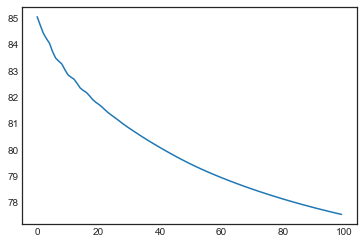

In [83]:
parameters = Parameters()
list_of_breakpoints = [10,20,30,40,50,60,70,80,99]
iteration=0
plot_loss_inner = []
for i in range(100):
    if pointer + T_steps >= len(train_data) or iteration == 0:
        g_h_prev = np.zeros((H_size, 1))
        g_C_prev = np.zeros((H_size, 1))
        pointer = 0
    inputs = XTrain[:T_steps]
    targets = yTrain[:T_steps]

    
    loss, g_h_prev, g_C_prev = \
        forward_backward(inputs, targets, g_h_prev, g_C_prev)
    smooth_loss = smooth_loss * 0.999 + loss * 0.001
    if iteration in list_of_breakpoints:
        print('prediction at breakpoint: ', iteration)
        print_status(inputs, g_h_prev, g_C_prev)

    update_paramters()
    plot_loss_inner = np.append(plot_loss_inner, [loss])

    pointer += T_steps
    iteration += 1

plt.plot(plot_loss_inner)



In [84]:
# Calculate numerical gradient
def calc_numerical_gradient(param, idx, delta, inputs, target, h_prev, C_prev):
    old_val = param.v.flat[idx]
    
    # evaluate loss at [x + delta] and [x - delta]
    param.v.flat[idx] = old_val + delta
    loss_plus_delta, _, _ = forward_backward(inputs, targets,
                                             h_prev, C_prev)
    param.v.flat[idx] = old_val - delta
    loss_mins_delta, _, _ = forward_backward(inputs, targets, 
                                             h_prev, C_prev)
    
    param.v.flat[idx] = old_val #reset

    grad_numerical = (loss_plus_delta - loss_mins_delta) / (2 * delta)
    # Clip numerical error because analytical gradient is clipped
    [grad_numerical] = np.clip([grad_numerical], -1, 1) 
    
    return grad_numerical


In [89]:
from random import uniform
# Check gradient of each paramter matrix/vector at `num_checks` individual values
def gradient_check(num_checks, delta, inputs, target, h_prev, C_prev):
    global parameters
    
    # To calculate computed gradients
    _, _, _ =  forward_backward(inputs, targets, h_prev, C_prev)
    
    
    for param in parameters.all():
        #Make a copy because this will get modified
        d_copy = np.copy(param.d)

        # Test num_checks times
        for i in range(num_checks):
            # Pick a random index
            rnd_idx = int(uniform(0, param.v.size))
            
            grad_numerical = calc_numerical_gradient(param,
                                                     rnd_idx,
                                                     delta,
                                                     inputs,
                                                     target,
                                                     h_prev, C_prev)
            grad_analytical = d_copy.flat[rnd_idx]

            err_sum = abs(grad_numerical + grad_analytical) + 1e-09
            rel_error = abs(grad_analytical - grad_numerical) / err_sum
            # If relative error is greater than 1e-06
            if rel_error > .05:
                print('%s (%e, %e) => %e'
                      % (param.name, grad_numerical, grad_analytical, rel_error))

In [90]:
parameters = Parameters()
iteration = 0

gradient_check(10, .005, [1,2,3,4], [2,3,4,5], g_h_prev, g_C_prev)

# Number of hidden units: Try doubling and halving your number of hidden units. And after training, plot the training loss vs the number of training epochs, and show the text sampling

In [91]:
# Constants and hyper-params
H_size = 20 # Size of the hidden layer
T_steps = 10
# Number of time steps (length of the sequence) used for training
learning_rate = .005# Learning rate
weight_sd = 0.1 # Standard deviation of weights for initialization
z_size = H_size + vocab_size # Size of concatenate(H, X) vector

In [92]:
# Parameters
# We use random weights with normal distribution (0, weight_sd) for  tanh  activation function 
# and (0.5, weight_sd) for  sigmoid  activation function.
# Biases are initialized to zeros.
class Param:
    def __init__(self, name, value):
        self.name = name
        self.v = value #parameter value
        self.d = np.zeros_like(value) #derivative
        self.m = np.zeros_like(value) #momentum for AdaGrad
        
class Parameters:
    def __init__(self):
        self.W_f = Param('W_f', 
                         np.random.randn(H_size, z_size) * weight_sd + 0.5)
        self.b_f = Param('b_f',
                         np.zeros((H_size, 1)))

        self.W_i = Param('W_i',
                         np.random.randn(H_size, z_size) * weight_sd + 0.5)
        self.b_i = Param('b_i',
                         np.zeros((H_size, 1)))

        self.W_C = Param('W_C',
                         np.random.randn(H_size, z_size) * weight_sd)
        self.b_C = Param('b_C',
                         np.zeros((H_size, 1)))

        self.W_o = Param('W_o',
                         np.random.randn(H_size, z_size) * weight_sd + 0.5)
        self.b_o = Param('b_o',
                         np.zeros((H_size, 1)))

        #For final layer to predict the next character
        self.W_v = Param('W_v',
                         np.random.randn(vocab_size, H_size) * weight_sd)
        self.b_v = Param('b_v',
                         np.zeros((vocab_size, 1)))
        
    def all(self):
        return [self.W_f, self.W_i, self.W_C, self.W_o, self.W_v,
               self.b_f, self.b_i, self.b_C, self.b_o, self.b_v]
        
parameters_double = Parameters()

def forward(x, h_prev, C_prev, p = parameters_double):
    assert x.shape == (vocab_size, 1)
    assert h_prev.shape == (H_size, 1)
    assert C_prev.shape == (H_size, 1)
    
    z = np.row_stack((h_prev, x))
    f = sigmoid(np.dot(p.W_f.v, z) + p.b_f.v)
    i = sigmoid(np.dot(p.W_i.v, z) + p.b_i.v)
    C_bar = tanh(np.dot(p.W_C.v, z) + p.b_C.v)

    C = f * C_prev + i * C_bar
    o = sigmoid(np.dot(p.W_o.v, z) + p.b_o.v)
    h = o * tanh(C)

    v = np.dot(p.W_v.v, h) + p.b_v.v
    y = np.exp(v) / np.sum(np.exp(v)) #softmax

    return z, f, i, C_bar, C, o, h, v, y

def backward(target, dh_next, dC_next, C_prev,
             z, f, i, C_bar, C, o, h, v, y,
             p = parameters_double):
    
    assert z.shape == (vocab_size + H_size, 1)
    assert v.shape == (vocab_size, 1)
    assert y.shape == (vocab_size, 1)
    
    for param in [dh_next, dC_next, C_prev, f, i, C_bar, C, o, h]:
        assert param.shape == (H_size, 1)
        
    dv = np.copy(y)
    dv[target] -= 1

    p.W_v.d += np.dot(dv, h.T)
    p.b_v.d += dv

    dh = np.dot(p.W_v.v.T, dv)        
    dh += dh_next
    do = dh * tanh(C)
    do = dsigmoid(o) * do
    p.W_o.d += np.dot(do, z.T)
    p.b_o.d += do

    dC = np.copy(dC_next)
    dC += dh * o * dtanh(tanh(C))
    dC_bar = dC * i
    dC_bar = dtanh(C_bar) * dC_bar
    p.W_C.d += np.dot(dC_bar, z.T)
    p.b_C.d += dC_bar

    di = dC * C_bar
    di = dsigmoid(i) * di
    p.W_i.d += np.dot(di, z.T)
    p.b_i.d += di

    df = dC * C_prev
    df = dsigmoid(f) * df
    p.W_f.d += np.dot(df, z.T)
    p.b_f.d += df

    dz = (np.dot(p.W_f.v.T, df)
         + np.dot(p.W_i.v.T, di)
         + np.dot(p.W_C.v.T, dC_bar)
         + np.dot(p.W_o.v.T, do))
    dh_prev = dz[:H_size, :]
    dC_prev = f * dC
    
    return dh_prev, dC_prev

# Clear gradients before each backward pass
def clear_gradients(params = parameters_double):
    for p in params.all():
        p.d.fill(0)
        
        
# Clip gradients to mitigate exploding gradients
def clip_gradients(params = parameters_double):
    for p in params.all():
        np.clip(p.d, -1, 1, out=p.d)
        
def forward_backward(inputs, targets, h_prev, C_prev):
    global paramters
    
    # To store the values for each time step
    x_s, z_s, f_s, i_s,  = {}, {}, {}, {}
    C_bar_s, C_s, o_s, h_s = {}, {}, {}, {}
    v_s, y_s =  {}, {}
    
    # Values at t - 1
    h_s[-1] = np.copy(h_prev)
    C_s[-1] = np.copy(C_prev)
    
    loss = 0
    # Loop through time steps
    for t in range(len(inputs)):
        x_s[t] = np.zeros((vocab_size, 1))
        x_s[t][inputs[t]] = 1 # Input character
        
        (z_s[t], f_s[t], i_s[t],
        C_bar_s[t], C_s[t], o_s[t], h_s[t],
        v_s[t], y_s[t]) = \
            forward(x_s[t], h_s[t - 1], C_s[t - 1]) # Forward pass
       
            
        loss += -np.log(y_s[t][len(targets[t]), 0]) # Loss for at t
        
    clear_gradients()

    dh_next = np.zeros_like(h_s[0]) #dh from the next character
    dC_next = np.zeros_like(C_s[0]) #dh from the next character

    for t in reversed(range(len(inputs))):
        # Backward pass
        dh_next, dC_next = \
            backward(target = targets[t], dh_next = dh_next,
                     dC_next = dC_next, C_prev = C_s[t-1],
                     z = z_s[t], f = f_s[t], i = i_s[t], C_bar = C_bar_s[t],
                     C = C_s[t], o = o_s[t], h = h_s[t], v = v_s[t],
                     y = y_s[t])

    clip_gradients()
        
    return loss, h_s[len(inputs) - 1], C_s[len(inputs) - 1]

def generate_next_char(h_prev, C_prev, first_char_idx, sentence_length):
    x = np.zeros((vocab_size, 1))
    x[first_char_idx] = 1

    h = h_prev
    C = C_prev

    indexes = []
    
    for t in range(sentence_length):
        _, _, _, _, C, _, h, _, p = forward(x, h, C)
        idx = np.random.choice(range(vocab_size), p=p.ravel())
        x = np.zeros((vocab_size, 1))
        x[idx] = 1
        indexes.append(idx)

    return indexes

# Update the graph and display a sample output
def update_status(inputs, h_prev, C_prev):
    #initialized later
    global plot_iter, plot_loss
    global smooth_loss
    
    # Get predictions for 200 letters with current model

    sample_idx = generate_next_char(h_prev, C_prev, inputs[0], 20)
    txt = ''.join(index_to_word[idx] for idx in sample_idx)

    # Clear and plot
    plt.plot(plot_iter, plot_loss)
    display.clear_output(wait=True)
    plt.show()

    #Print prediction and loss
    print("----\n %s \n----" % (txt, ))
    print("iter %d, loss %f" % (iteration, smooth_loss))
    
def update_paramters(params = parameters_double):
    for p in params.all():
        p.m += p.d * p.d # Calculate sum of gradients
        #print(learning_rate * dparam)
        p.v += -(learning_rate * p.d / np.sqrt(p.m + 1e-8))
        
# Exponential average of loss
# Initialize to a error of a random model
smooth_loss = -np.log(1.0 / vocab_size) * T_steps

iteration, pointer = 0, 0

# For the graph
plot_iter = np.zeros((0))
plot_loss = np.zeros((0))

# Update the graph and display a sample output
def print_status(inputs, h_prev, C_prev):
    # Get predictions for 200 letters with current model
    sample_idx = generate_next_char(h_prev, C_prev, inputs[0], 20)
    txt = ' '.join(index_to_word[idx] for idx in sample_idx)
    # Clear and plot
    #plt.plot(plot_iter, plot_loss)
    #display.clear_output(wait=True)
    #plt.show()
    #Print prediction and loss
    print("----\n %s \n----" % (txt, ))

prediction at breakpoint:  10
----
 collection end imaginable comprehend sped carolina neither wandering garden treated somewhat compasses boy creating attempt floated disagreeable design planetary seizing 
----
prediction at breakpoint:  20
----
 shots gloomy acid bearing disk brought damages shrug fierce gay recognized tool faded flanks hall weeks steam bed org toledo 
----
prediction at breakpoint:  30
----
 effort tremendous open added bring 000 set hours sweep ends consideration declared attraction denizens child 1 wondered difficulties forehead had 
----
prediction at breakpoint:  40
----
 larger version mechanical sparkling gentlemen 28 kept miserable below travelers applause produced continue latin imagined lapse f visions vegetable notes 
----
prediction at breakpoint:  50
----
 phrase mixed bears thrown example fatality updated cable acoustic gallery purposes change lost is blows similar available badly float chlorate 
----
prediction at breakpoint:  60
----
 silver might ins

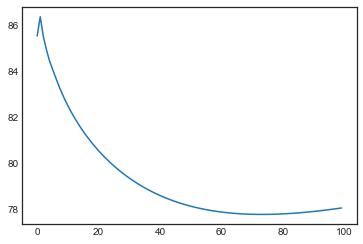

In [93]:

list_of_breakpoints = [10,20,30,40,50,60,70,80,99]
iteration=0
plot_loss_inner = []
# print('input characters')
# print('%s'%" ".join([index_to_word[x] for x in inputs]))
for i in range(100):
    if pointer + T_steps >= len(train_data) or iteration == 0:
        g_h_prev = np.zeros((H_size, 1))
        g_C_prev = np.zeros((H_size, 1))
        pointer = 0
        inputs = XTrain[:T_steps]
        targets = yTrain[:T_steps]
    
    


    loss, g_h_prev, g_C_prev = \
        forward_backward(inputs, targets, g_h_prev, g_C_prev)
    smooth_loss = smooth_loss * 0.999 + loss * 0.001
    if iteration in list_of_breakpoints:
        print('prediction at breakpoint: ', iteration)
        print_status(inputs, g_h_prev, g_C_prev)

    update_paramters()
    plot_loss_inner = np.append(plot_loss_inner, [loss])

    pointer += T_steps
    iteration += 1

plt.plot(plot_loss_inner)


        

# Halving hidden units

In [97]:
# Constants and hyper-params
H_size = 5 # Size of the hidden layer
T_steps = 10
# Number of time steps (length of the sequence) used for training
learning_rate = .005 # Learning rate
weight_sd = 0.1 # Standard deviation of weights for initialization
z_size = H_size + vocab_size # Size of concatenate(H, X) vector

In [98]:
# Parameters
# We use random weights with normal distribution (0, weight_sd) for  tanh  activation function 
# and (0.5, weight_sd) for  sigmoid  activation function.
# Biases are initialized to zeros.
class Param:
    def __init__(self, name, value):
        self.name = name
        self.v = value #parameter value
        self.d = np.zeros_like(value) #derivative
        self.m = np.zeros_like(value) #momentum for AdaGrad
        
class Parameters:
    def __init__(self):
        self.W_f = Param('W_f', 
                         np.random.randn(H_size, z_size) * weight_sd + 0.5)
        self.b_f = Param('b_f',
                         np.zeros((H_size, 1)))

        self.W_i = Param('W_i',
                         np.random.randn(H_size, z_size) * weight_sd + 0.5)
        self.b_i = Param('b_i',
                         np.zeros((H_size, 1)))

        self.W_C = Param('W_C',
                         np.random.randn(H_size, z_size) * weight_sd)
        self.b_C = Param('b_C',
                         np.zeros((H_size, 1)))

        self.W_o = Param('W_o',
                         np.random.randn(H_size, z_size) * weight_sd + 0.5)
        self.b_o = Param('b_o',
                         np.zeros((H_size, 1)))

        #For final layer to predict the next character
        self.W_v = Param('W_v',
                         np.random.randn(vocab_size, H_size) * weight_sd)
        self.b_v = Param('b_v',
                         np.zeros((vocab_size, 1)))
        
    def all(self):
        return [self.W_f, self.W_i, self.W_C, self.W_o, self.W_v,
               self.b_f, self.b_i, self.b_C, self.b_o, self.b_v]
        
parameters_half = Parameters()

def forward(x, h_prev, C_prev, p = parameters_half):
    assert x.shape == (vocab_size, 1)
    assert h_prev.shape == (H_size, 1)
    assert C_prev.shape == (H_size, 1)
    
    z = np.row_stack((h_prev, x))
    f = sigmoid(np.dot(p.W_f.v, z) + p.b_f.v)
    i = sigmoid(np.dot(p.W_i.v, z) + p.b_i.v)
    C_bar = tanh(np.dot(p.W_C.v, z) + p.b_C.v)

    C = f * C_prev + i * C_bar
    o = sigmoid(np.dot(p.W_o.v, z) + p.b_o.v)
    h = o * tanh(C)

    v = np.dot(p.W_v.v, h) + p.b_v.v
    y = np.exp(v) / np.sum(np.exp(v)) #softmax

    return z, f, i, C_bar, C, o, h, v, y

def backward(target, dh_next, dC_next, C_prev,
             z, f, i, C_bar, C, o, h, v, y,
             p = parameters_half):
    
    assert z.shape == (vocab_size + H_size, 1)
    assert v.shape == (vocab_size, 1)
    assert y.shape == (vocab_size, 1)
    
    for param in [dh_next, dC_next, C_prev, f, i, C_bar, C, o, h]:
        assert param.shape == (H_size, 1)
        
    dv = np.copy(y)
    dv[target] -= 1

    p.W_v.d += np.dot(dv, h.T)
    p.b_v.d += dv

    dh = np.dot(p.W_v.v.T, dv)        
    dh += dh_next
    do = dh * tanh(C)
    do = dsigmoid(o) * do
    p.W_o.d += np.dot(do, z.T)
    p.b_o.d += do

    dC = np.copy(dC_next)
    dC += dh * o * dtanh(tanh(C))
    dC_bar = dC * i
    dC_bar = dtanh(C_bar) * dC_bar
    p.W_C.d += np.dot(dC_bar, z.T)
    p.b_C.d += dC_bar

    di = dC * C_bar
    di = dsigmoid(i) * di
    p.W_i.d += np.dot(di, z.T)
    p.b_i.d += di

    df = dC * C_prev
    df = dsigmoid(f) * df
    p.W_f.d += np.dot(df, z.T)
    p.b_f.d += df

    dz = (np.dot(p.W_f.v.T, df)
         + np.dot(p.W_i.v.T, di)
         + np.dot(p.W_C.v.T, dC_bar)
         + np.dot(p.W_o.v.T, do))
    dh_prev = dz[:H_size, :]
    dC_prev = f * dC
    
    return dh_prev, dC_prev

# Clear gradients before each backward pass
def clear_gradients(params = parameters_half):
    for p in params.all():
        p.d.fill(0)
        
        
# Clip gradients to mitigate exploding gradients
def clip_gradients(params = parameters_half):
    for p in params.all():
        np.clip(p.d, -1, 1, out=p.d)
        
def forward_backward(inputs, targets, h_prev, C_prev):
    global paramters
    
    # To store the values for each time step
    x_s, z_s, f_s, i_s,  = {}, {}, {}, {}
    C_bar_s, C_s, o_s, h_s = {}, {}, {}, {}
    v_s, y_s =  {}, {}
    
    # Values at t - 1
    h_s[-1] = np.copy(h_prev)
    C_s[-1] = np.copy(C_prev)
    
    loss = 0
    # Loop through time steps
    for t in range(len(inputs)):
        x_s[t] = np.zeros((vocab_size, 1))
        x_s[t][inputs[t]] = 1 # Input character
        
        (z_s[t], f_s[t], i_s[t],
        C_bar_s[t], C_s[t], o_s[t], h_s[t],
        v_s[t], y_s[t]) = \
            forward(x_s[t], h_s[t - 1], C_s[t - 1]) # Forward pass
       
            
        loss += -np.log(y_s[t][len(targets[t]), 0]) # Loss for at t
        
    clear_gradients()

    dh_next = np.zeros_like(h_s[0]) #dh from the next character
    dC_next = np.zeros_like(C_s[0]) #dh from the next character

    for t in reversed(range(len(inputs))):
        # Backward pass
        dh_next, dC_next = \
            backward(target = targets[t], dh_next = dh_next,
                     dC_next = dC_next, C_prev = C_s[t-1],
                     z = z_s[t], f = f_s[t], i = i_s[t], C_bar = C_bar_s[t],
                     C = C_s[t], o = o_s[t], h = h_s[t], v = v_s[t],
                     y = y_s[t])

    clip_gradients()
        
    return loss, h_s[len(inputs) - 1], C_s[len(inputs) - 1]

def generate_next_char(h_prev, C_prev, first_char_idx, sentence_length):
    x = np.zeros((vocab_size, 1))
    x[first_char_idx] = 1

    h = h_prev
    C = C_prev

    indexes = []
    
    for t in range(sentence_length):
        _, _, _, _, C, _, h, _, p = forward(x, h, C)
        idx = np.random.choice(range(vocab_size), p=p.ravel())
        x = np.zeros((vocab_size, 1))
        x[idx] = 1
        indexes.append(idx)

    return indexes

# Update the graph and display a sample output
def update_status(inputs, h_prev, C_prev):
    #initialized later
    global plot_iter, plot_loss
    global smooth_loss
    
    # Get predictions for 200 letters with current model

    sample_idx = generate_next_char(h_prev, C_prev, inputs[0], 20)
    txt = ''.join(index_to_word[idx] for idx in sample_idx)

    # Clear and plot
    plt.plot(plot_iter, plot_loss)
    display.clear_output(wait=True)
    plt.show()

    #Print prediction and loss
    print("----\n %s \n----" % (txt, ))
    print("iter %d, loss %f" % (iteration, smooth_loss))
    
def update_paramters(params = parameters_half):
    for p in params.all():
        p.m += p.d * p.d # Calculate sum of gradients
        #print(learning_rate * dparam)
        p.v += -(learning_rate * p.d / np.sqrt(p.m + 1e-8))
        
# Exponential average of loss
# Initialize to a error of a random model
smooth_loss = -np.log(1.0 / vocab_size) * T_steps

iteration, pointer = 0, 0

# For the graph
plot_iter = np.zeros((0))
plot_loss = np.zeros((0))

# Update the graph and display a sample output
def print_status(inputs, h_prev, C_prev):
    # Get predictions for 200 letters with current model
    sample_idx = generate_next_char(h_prev, C_prev, inputs[0], 20)
    txt = ' '.join(index_to_word[idx] for idx in sample_idx)
    # Clear and plot
    #plt.plot(plot_iter, plot_loss)
    #display.clear_output(wait=True)
    #plt.show()
    #Print prediction and loss
    print("----\n %s \n----" % (txt, ))

prediction at breakpoint:  10
----
 humors reappeared decidedly granitic glory distribute resembled scandinavian dying checked electronic inches crushed stage means seventeen tear not seconds friends 
----
prediction at breakpoint:  20
----
 stretched compose deprived count merry searched depths take color longer donate chamber wind b flight noticed turf contradiction resolution equally 
----
prediction at breakpoint:  30
----
 badly reported task active solution indignant SENTENCE_END federal hiding admit institute contains flight columbiad dazzled spark hillisborough asleep sped faintest 
----
prediction at breakpoint:  40
----
 rough calm brings pity sought mile literally mahomet passenger class assemblage wire ebooks limbs importance conditions conviction precipitated forward tore 
----
prediction at breakpoint:  50
----
 warned prospect tear dollars people hearty compared remain arne answered stray others readable twice given 19 bundles rid 25 match 
----
prediction at breakpoint:

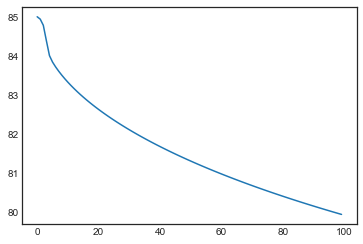

In [99]:
list_of_breakpoints = [10,20,30,40,50,60,70,80,99]
iteration=0
plot_loss_inner = []
# print('input characters')
# print('%s'%" ".join([index_to_word[x] for x in inputs]))
for i in range(100):
    if pointer + T_steps >= len(train_data) or iteration == 0:
        g_h_prev = np.zeros((H_size, 1))
        g_C_prev = np.zeros((H_size, 1))
        pointer = 0
        inputs = XTrain[:T_steps]
        targets = yTrain[:T_steps]
    
    


    loss, g_h_prev, g_C_prev = \
        forward_backward(inputs, targets, g_h_prev, g_C_prev)
    smooth_loss = smooth_loss * 0.999 + loss * 0.001
    if iteration in list_of_breakpoints:
        print('prediction at breakpoint: ', iteration)
        print_status(inputs, g_h_prev, g_C_prev)

    update_paramters()
    plot_loss_inner = np.append(plot_loss_inner, [loss])

    pointer += T_steps
    iteration += 1

plt.plot(plot_loss_inner)



# Observation 

## Doubling hidden units

- Processing time increased

- Initially loss decreased to a lower point then increased

- word prediction was not good for initial epochs but I hope it will eventually improve with epoch

## Halving hidden units

- Processing time decreased

- loss was lower than other two

- character prediction improved 

# Sequence length: Try doubling and halving your length of sequence that feeds into the network. And after training, plot the training loss vs the number of training epochs, and show the text sampling results. 

prediction at breakpoint:  10
----
 top summit fill mystery moral gravity permission clock redistributing catastrophe hansbach region risk consider miss vii permitted won high destroyed 
----
prediction at breakpoint:  20
----
 pole each leading 2 pencil portion writing fantastic atmospheres once change observatory francs high tenacity highly overcome amid 25 superb 
----
prediction at breakpoint:  30
----
 eagles imagination approve castle phenomenon compact www solely tenacity work accordingly examine northwest initial lighting contracted neutral glance summit regularly 
----
prediction at breakpoint:  40
----
 knocked 24 tomb course nodded xx painful yourselves empty formidable humphry luminous however peculiarly packed primitive expecting turn plan still 
----
prediction at breakpoint:  50
----
 maps hundred across intelligent recovered weigh humphry machinery sealed 150 signature which gaping inert driver attractive cared wretched road left 
----
prediction at breakpoint:  60
----

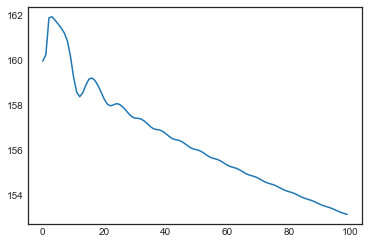

In [100]:
##Doubling


T_steps_double = T_steps * 2 
parameters = Parameters()
list_of_breakpoints = [10,20,30,40,50,60,70,80,99]
iteration=0
plot_loss_inner = []


for i in range(100):
    if pointer + T_steps_double >= len(train_data) or iteration == 0:
        g_h_prev = np.zeros((H_size, 1))
        g_C_prev = np.zeros((H_size, 1))
        pointer = 0
    inputs = XTrain[:T_steps_double]
    targets = yTrain[:T_steps_double]
    

    loss, g_h_prev, g_C_prev = \
        forward_backward(inputs, targets, g_h_prev, g_C_prev)
    smooth_loss = smooth_loss * 0.999 + loss * 0.001
    if iteration in list_of_breakpoints:
        print('prediction at breakpoint: ', iteration)
        print_status(inputs, g_h_prev, g_C_prev)

    update_paramters()
    plot_loss_inner = np.append(plot_loss_inner, [loss])

    pointer += T_steps_double
    iteration += 1

plt.plot(plot_loss_inner)




prediction at breakpoint:  10
----
 all distant elphinstone fiery informed being audience theories eagerness frail falls sloping pronounced who performances mad successful impetus deal reduced 
----
prediction at breakpoint:  20
----
 resembled illness correctness drank morrow land goes beds beach deaden supports irradiation 7 steadily canada erie 90 requiring restore locality 
----
prediction at breakpoint:  30
----
 anguish crushed covering astounding person 5 blue birth meat landed terrible fixed schiedam seminoles enclosure doubled carved vast profound her 
----
prediction at breakpoint:  40
----
 entered reserved persist talking conceal wonderful castle lack 8 assistants approaches heaps cylindro 11th burnt port rations monstrous consisting individual 
----
prediction at breakpoint:  50
----
 iceland subterraneous concept telescope safe net vain darting reality maneuver belongs arise sixty safely 9 city watched hunter operation july 
----
prediction at breakpoint:  60
----
 save o

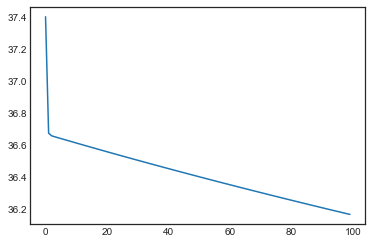

In [101]:
##Halving


T_steps_half = T_steps // 2 
parameters = Parameters()
list_of_breakpoints = [10,20,30,40,50,60,70,80,99]
iteration=0
plot_loss_inner = []


for i in range(100):
    if pointer + T_steps_half >= len(train_data) or iteration == 0:
        g_h_prev = np.zeros((H_size, 1))
        g_C_prev = np.zeros((H_size, 1))
        pointer = 0
    inputs = XTrain[:T_steps_half]
    targets = yTrain[:T_steps_half]
    

    loss, g_h_prev, g_C_prev = \
        forward_backward(inputs, targets, g_h_prev, g_C_prev)
    smooth_loss = smooth_loss * 0.999 + loss * 0.001
    if iteration in list_of_breakpoints:
        print('prediction at breakpoint: ', iteration)
        print_status(inputs, g_h_prev, g_C_prev)

    update_paramters()
    plot_loss_inner = np.append(plot_loss_inner, [loss])

    pointer += T_steps_double
    iteration += 1

plt.plot(plot_loss_inner)




# Observation

## doubling sequence length

- Loss did not decrease much than previous graph

- processing time increased



## halving sequence length

- Loss became much low 

- processing time decreased

